In [1]:
import torch
import os
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import matplotlib.animation as anim

In [2]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_set = datasets.MNIST('../../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
val_set = datasets.MNIST('../../data', train=False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1000)

/home/javier/workspace/nn_distributed_training/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
results_dir = "../../results/2021-09-27_10-50_dist_mnist_anim"
results = torch.load(os.path.join(results_dir, "dinno_results.pt"), map_location=torch.device("cpu"))
print("Num Frames ", len(results["validation_as_vector"]))

Num Frames  151


In [4]:
def init_mnist_grid(axs, dataset, inds):
    nrows, ncols = axs.shape
    bwidth = 2
    
    for i in range(nrows):
        for j in range(ncols):
            raw_img = dataset[inds[i, j]][0].reshape(28, 28)
            axs[i, j].imshow(raw_img, cmap="gray")
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticklabels([])
            axs[i, j].set_yticks([])

def update_borders(axs, correct):
    nrows, ncols = axs.shape
    bwidth = 2
    
    for i in range(nrows):
        for j in range(ncols):
            if correct[i, j]:
                bcolor = "springgreen"
            else:
                bcolor = "orangered"
                
            for spine in axs[i, j].spines.values():
                spine.set_edgecolor(bcolor)
                spine.set_linewidth(10)

    return


In [5]:
# Pick indices making sure that there are some wrong classiciations at the end
vvecs = results["validation_as_vector"]
num_wrong = 2
num_total = 100

wrongs = []
for i in range(10):
    wrongs.append((vvecs[-1][i] == False).nonzero()[:, 0].reshape(-1, 1))

wrongs = torch.vstack(wrongs)
uns, counts = torch.unique(wrongs, return_counts=True)
all_wrong = uns[counts == 10]
all_wrong = all_wrong[torch.randperm(all_wrong.shape[0])]

inds = torch.vstack([torch.arange(0, num_total - num_wrong).reshape(-1, 1), all_wrong[:num_wrong].reshape(-1, 1)]).reshape(-1)
print(all_wrong[:num_wrong])

tensor([4807, 1393])


/home/javier/workspace/nn_distributed_training/venv/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


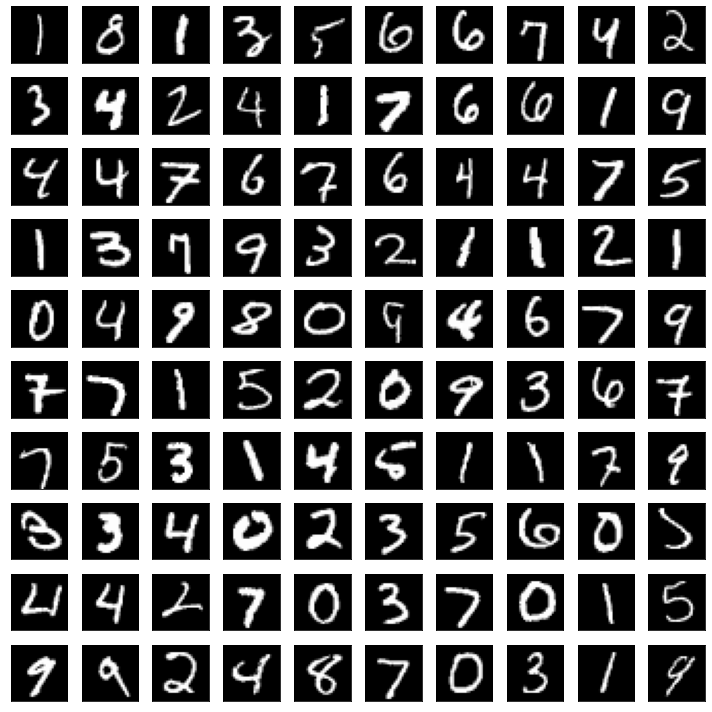

In [6]:
grid_shape = (10, 10)
torch.manual_seed(100)
inds = inds[torch.randperm(inds.size()[0])].reshape(grid_shape)
num_frames = len(vvecs)
node = 0

(fig, axs) = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 10), tight_layout=True)

for node in range(10):
    def draw(i):
        correct = results["validation_as_vector"][i][node][inds]
        update_borders(axs, correct)

    mnist_anim = anim.FuncAnimation(fig, draw, frames=num_frames, repeat=False, init_func=init_mnist_grid(axs, val_set, inds)) 
    #mnist_anim.save("mnist_vids/{}.mp4".format(node), dpi=300, fps=20, bitrate=3000)

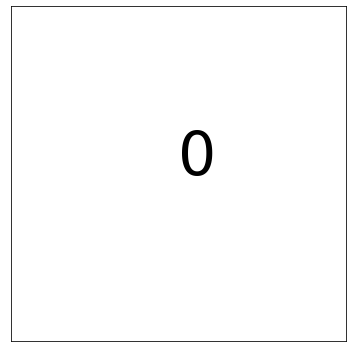

In [7]:
(fig, ax) = plt.subplots(tight_layout=True, figsize=(5, 5))
ttext = ax.text(0.5, 0.5, "", fontsize=60)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

def update_iterations(i):
    ttext.set_text("{}".format(i * 20))
    return ttext,

itanim = anim.FuncAnimation(fig, update_iterations, frames=num_frames, blit=True)
#itanim.save("mnist_vids/iters.mp4", dpi=300, fps=20, bitrate=2000)

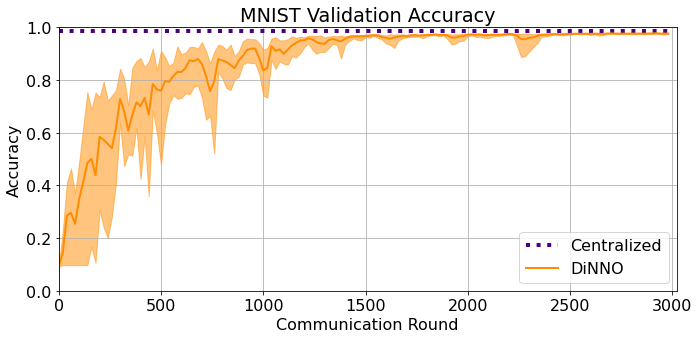

In [19]:
(fig, ax) = plt.subplots(tight_layout=True, figsize=(10, 5))
plt.rcParams.update({'font.size': 16})

ax.set_title("MNIST Validation Accuracy")

acc = torch.stack(results["top1_accuracy"])

mean_acc = torch.mean(acc, dim=1)
lb = torch.amin(acc, dim=1) 
ub = torch.amax(acc, dim=1) 
t = torch.arange(mean_acc.shape[0]) * 20
ax.plot(t, 0.985 * torch.ones_like(t), linestyle=":",linewidth=4, color="indigo", label="Centralized")
lmean = ax.plot(0, mean_acc[0], linewidth=2, c="darkorange", label="DiNNO")
fb = ax.fill_between(t[:1], lb[:1], ub[:1], color="darkorange", alpha=0.5)
ax.legend(loc=4)
ax.set_ylim([0, 1])
ax.set_xlim([0, num_frames*20])
ax.grid()

def update_valplot(i):
    ax.cla()
    ax.set_title("MNIST Validation Accuracy")
    ax.plot(t, 0.985 * torch.ones_like(t), linestyle=":",linewidth=4, color="indigo", label="Centralized")
    ax.plot(t[:i], mean_acc[:i], linewidth=2, c="darkorange", label="DiNNO")
    ax.fill_between(t[:i], lb[:i], ub[:i], color="darkorange", alpha=0.5)
    ax.legend(loc=4)
    ax.set_xlim([0, num_frames*20])
    ax.set_ylim([0, 1])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Communication Round")
    ax.grid()

valanim = anim.FuncAnimation(fig, update_valplot, frames=num_frames)
valanim.save("mnist_vids/val.mp4", dpi=300, fps=20, bitrate=3000)
    

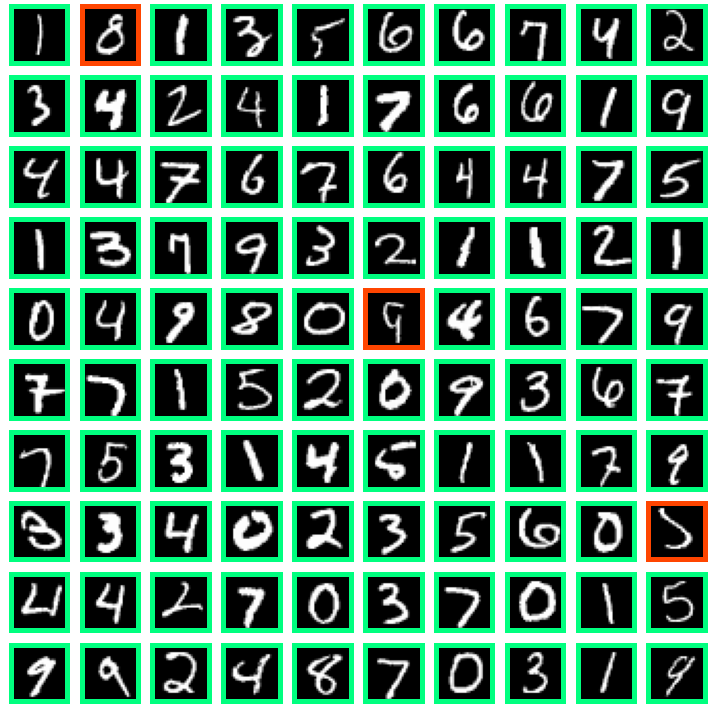

In [9]:
(fig, axs) = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 10), tight_layout=True)
init_mnist_grid(axs, val_set, inds)
correct = results["validation_as_vector"][-10][0][inds]
update_borders(axs, correct)

fig.savefig("mnist_vids/example_val.png", dpi=800)


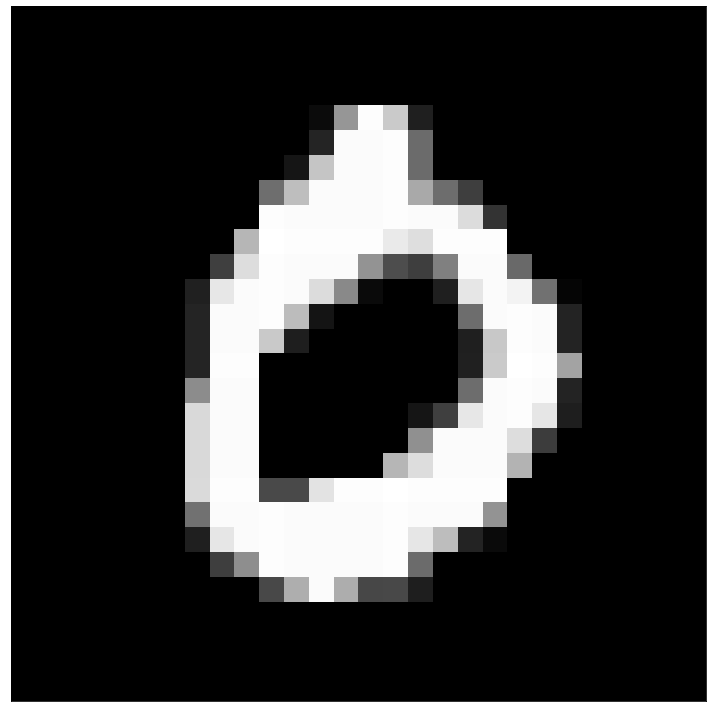

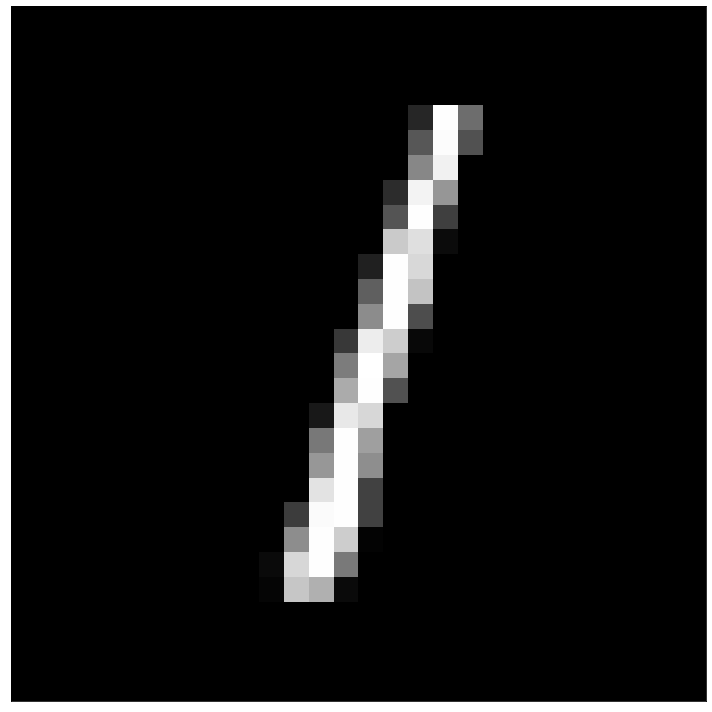

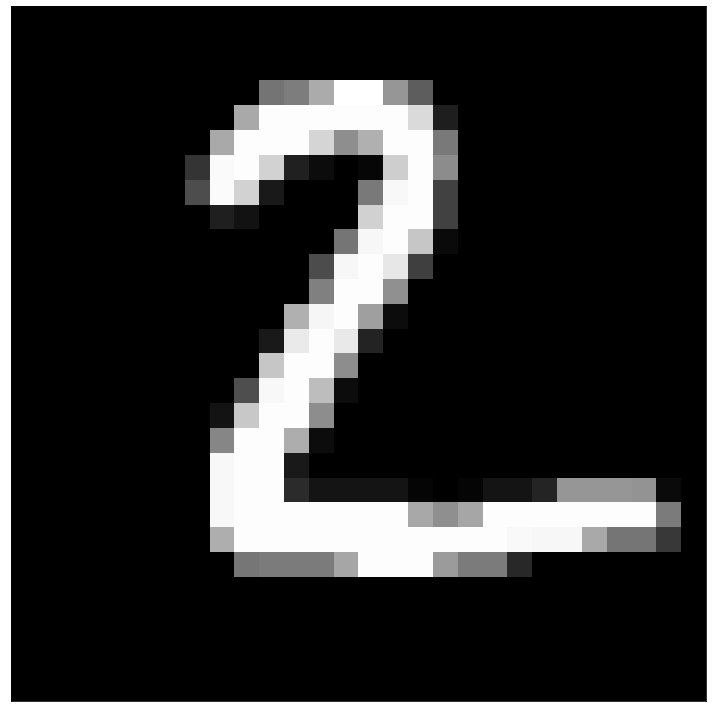

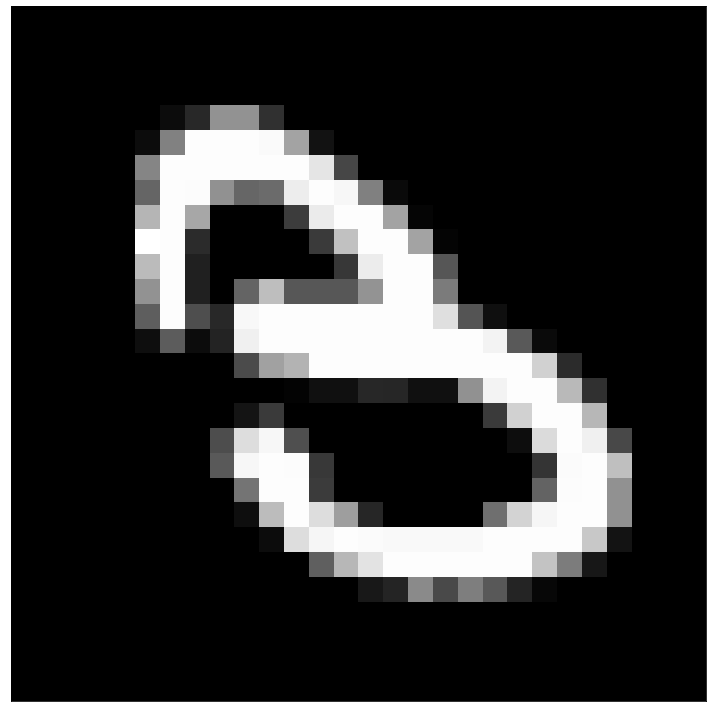

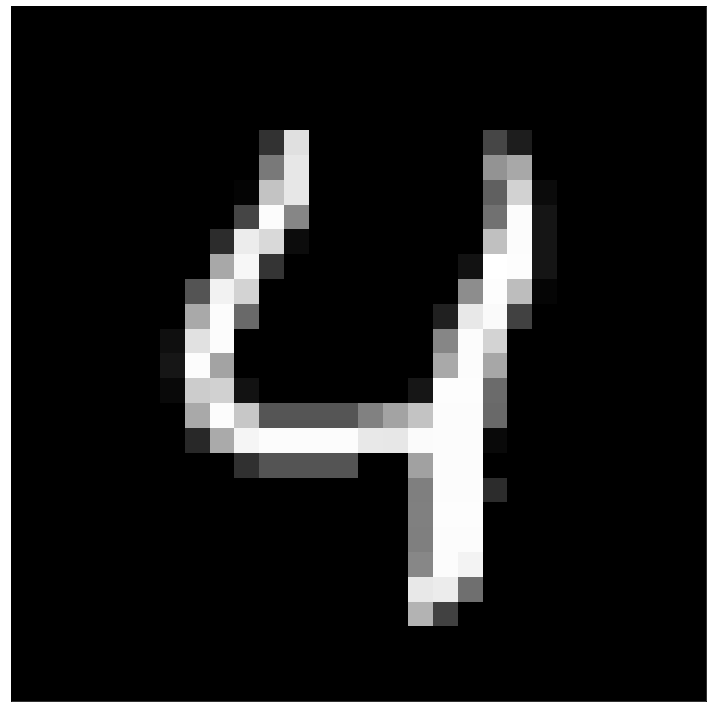

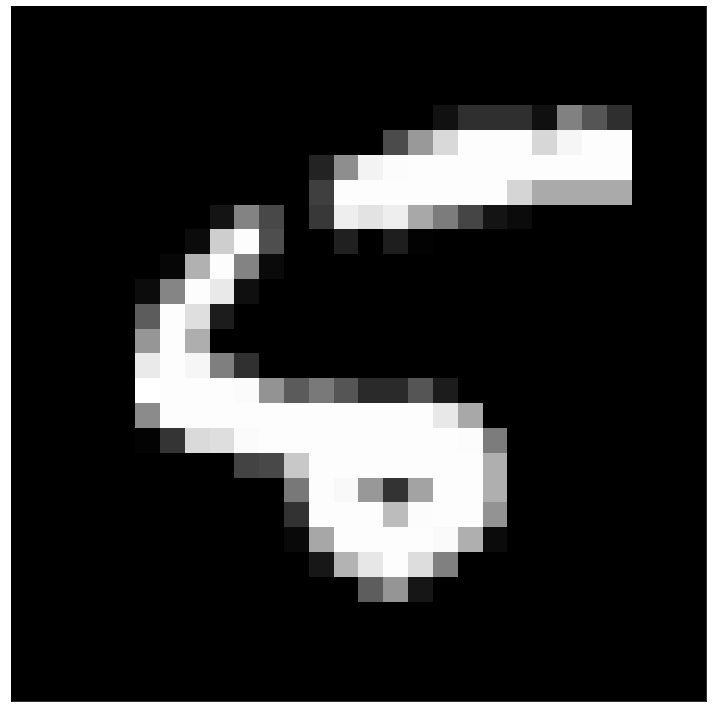

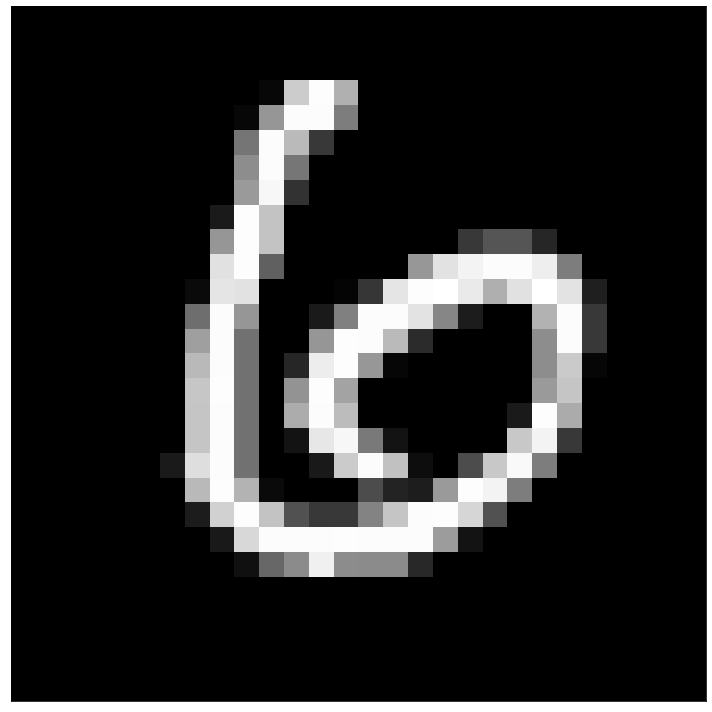

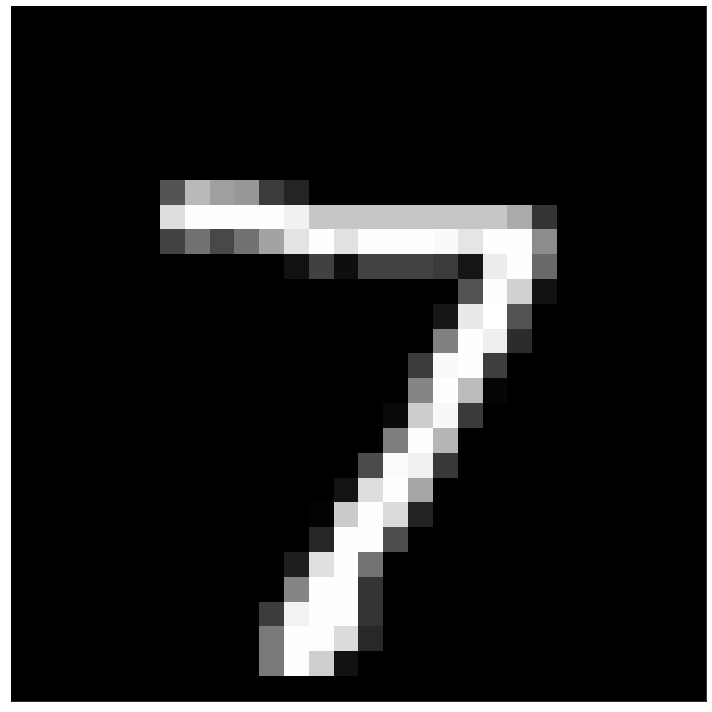

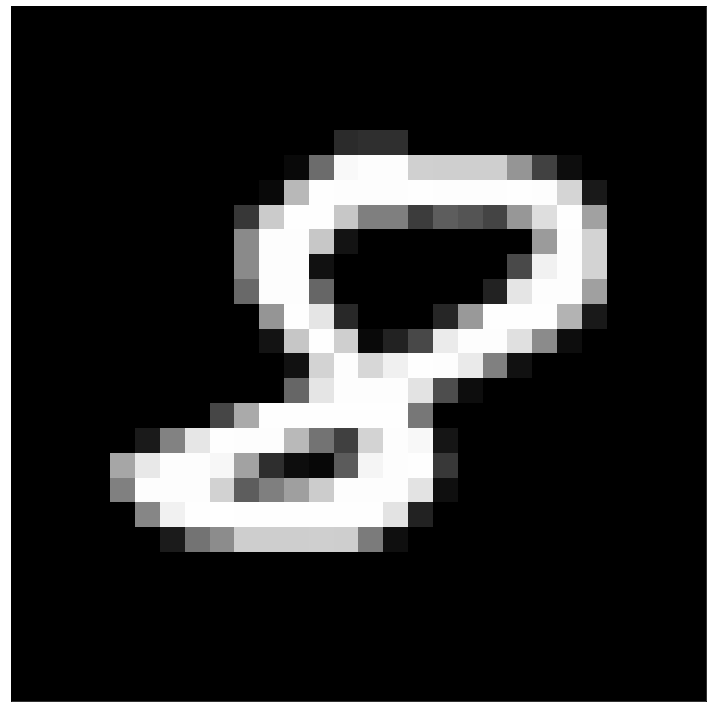

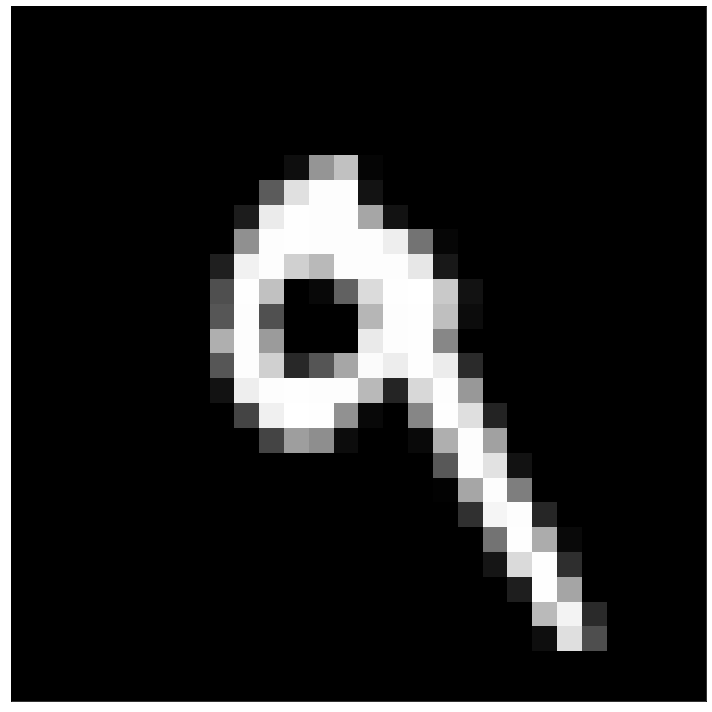

In [10]:
for i in range(10):
    (fig, ax) = plt.subplots(tight_layout=True, figsize=(10, 10))
    ind = torch.where(val_set.targets == i)[0][0]
    ax.imshow(val_set[ind][0].reshape(28, 28), cmap="gray")
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    fig.savefig("mnist_vids/{}_img.png".format(i))